In [47]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
%gui qt5

# Download benchmark data

In [ ]:

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/561"
mip = 0

vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_bg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/642"
mip = 0

vol_fg = CloudVolume(dir)
shape = vol_fg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
dir = "s3://smartspim-precomputed-volumes/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
mip = 0

vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_mask.shape
print(shape)


In [ ]:
centers_train = [[2477, 3638, 2409], [3605, 2873, 2405], [4939, 5186, 2398], [4538, 5148, 2398], [4618, 3225, 2388], [3223, 5206, 3550], [1953, 2102, 3577], [2395, 5004, 3584], [941, 3711, 708], [2030, 2164, 701], [3283, 3406, 1255], [1531, 2220, 1242], [2569, 6420, 2924], [2282, 8206, 2924], [4424, 5689, 2896], [3269, 3987, 2896], [2817, 6831, 4565], [3308, 3276, 4124], [4560, 6354, 4133], [4293, 2411, 2297], [5254, 5429, 2877], [3851, 2185, 2877], [2261, 8272, 2877], [3970, 3496, 2877], [1277, 2284, 2877]]
centers_val = [[5701, 3357, 4137], [3610, 2346, 4137], [2564, 4086, 2829], [1282, 2182, 2829], [3960, 2836, 1546], [2347, 4866, 1545], [1680, 4284, 806], [3223, 3294, 2514], [3564, 3847, 2516], [2620, 7237, 4610]]

In [ ]:
for i, center in enumerate(centers_train):
    if i < 20:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

## View data

In [ ]:
center = centers_train[23]

image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_fg = image_fg[:,:,:,0]

image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_bg = image_bg[:,:,:,0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)

## Check training results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0

for i in range(20):
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    f = h5py.File(fname, 'r')
    im = f.get('image_2channel')
    im_bg = im[0,:,:,:]
    im_fg = im[1,:,:,:]

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Labels.h5"
    f = h5py.File(fname, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2
    num_pos_labels = np.sum(pos_labels)

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Probabilities.h5"
    f = h5py.File(fname, 'r')
    seg = f.get('exported_data')
    seg = seg[1,:,:,:]
    mask = seg > 0.5

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels
    
    if num_pos_labels > 0:
        precision = true_pos/(true_pos + false_pos)
        recall = true_pos/true_labels
        print(f"Example {i}: precision: {precision}, recall: {recall}")
    else:
        print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")

    '''
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im_bg)
    viewer.add_image(im_fg)
    viewer.add_labels(gt)
    viewer.add_labels(mask)
    '''
print(f"Total precision: {true_pos_total/(true_pos_total + false_pos_total)} total recall: {true_pos_total/true_labels_total} with {true_labels_total} total positive voxels")

## Check Val results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
spacing =  0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass
        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        '''
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total} total pos voxels. F-score: {fscore:.4f}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)
plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore:.4f}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain1')
plt.legend()

## Brain 2 

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"
mip = 0

vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_fg.shape
print(shape)

centers_val = [[2626,3837,2366],[799,3315,2366],[3851,5443,2346],[3260,5490,2351],[3198,7658,2351],[2998,4502,1215],[4269,1657,1215],[3071,1153,3412],[3672,1792,409],[2235,4195,409]]

In [ ]:
# download data
for i, center in enumerate(centers_val):
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain 2')
plt.legend()

## Check whole brain results

In [ ]:
#download from cloud
centers = [[2304, 3840, 2100], [2560, 3840, 1800]]

for i,center in enumerate(centers):
    image_fg = vol_fg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_bg = image_bg[:,:,:,0]

    mask_s3 = vol_mask[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    mask_s3 = mask_s3[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

    

In [ ]:
#read ilastik output
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_1_Probabilities.h5"
f = h5py.File(fname, 'r')
im = f.get('exported_data')
pred = im[1,:,:,:]
mask = pred > 0.32

In [ ]:
#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
image_fg_cis = im[1,:,:,:,0]
image_bg_cis = im[0,:,:,:,0]

#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800_Probabilities.h5"
f = h5py.File(fname, 'r')
ks = list(f.keys())
pred = f[ks[0]]
pred_cis = pred[1,:,:,:]
pred_cis = np.squeeze(pred_cis)
mask_cis = pred_cis > 0.32

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)
viewer.add_labels(mask_s3)
viewer.add_labels(mask)
viewer.add_image(image_fg_cis)
viewer.add_image(image_bg_cis)
viewer.add_labels(mask_cis)
napari.run()

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh",  "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Brain 3

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_647"
mip = 0
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_561"
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_488"
vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
print(vol_endo.shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/atlas_to_target"
vol_reg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

centers_train = [[3007, 4546, 2697], [4466, 4467, 2697], [2670, 606, 2700], [1135, 751, 2700], [2354, 793, 1686], [327, 3241, 1686], [3961, 5206, 1686], [2852, 5223, 1686], [3574, 5145, 3261], [3566, 1245, 1399],
                [836, 2652, 1399], [2232, 6470, 1399], [2274, 3788, 2248], [2286, 1678, 2248], [4215, 1992, 2248], [2974, 2556, 2711], [2133, 2004, 2711], [3942, 5743, 2711], [2600, 5259, 485], [3090, 3676, 485],
                [1341, 5648, 2227], [1013, 4294, 2227], [3341, 3992, 2227], [1772, 5628, 3011], [1039, 5685, 1038], [2170, 3928, 1861], [3040, 3047, 1861]]
centers_val = [[2639, 513, 2432], [4592, 4209, 2432], [4234, 4105, 3331], [2067, 4007, 1683], [4764, 2569, 1683], [2579, 2759, 583], [3244, 3921, 575], [2298, 1555, 575], [3081, 4587, 2971], [3402, 6232, 2697],
                [4426, 4334, 1038], [857, 2867, 1038], [1665, 5523, 2391], [2027, 4258, 1861]]

## Download 3 channel data

In [ ]:
# download data
for i, center in enumerate(centers_val):
    if i < 0:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]

    image_endo = vol_endo[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_endo = image_endo[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg, image_endo], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain4/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

## View 3 channel data

In [ ]:
#view volumes
i = 6
set = "val"
brain = 4

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/" + set + "_" + str(i) + ".h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    image_bg = im[0,:,:,:]
    image_fg = im[1,:,:,:]
    image_endo = im[2,:,:,:]
    print(im.shape)

viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')
viewer.add_image(image_bg)
viewer.add_image(image_endo)
viewer.add_image(image_fg)
napari.run()  

In [ ]:

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    image_bg = im[0,:,:,:,0]
    image_fg = im[1,:,:,:,0]
    image_endo = im[2,:,:,:,0]
    print(im.shape)

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0_Probabilities.h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    probs = im[1,:,:,:,0]
    print(im.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_bg)
viewer.add_image(image_endo)
viewer.add_image(image_fg)
viewer.add_image(probs)
napari.run()  

## Compute precision recall

In [ ]:
brain = 4

true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(7):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Validation Performance Brain ' + str(brain))
plt.legend()

## Atlas readout

In [ ]:
volumes = {}
for x in tqdm(np.arange(0, vol_mask.shape[0], 128)):
    x2 = np.amin([x+128, vol_mask.shape[0]])
    for y in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
        y2 = np.amin([x+128, vol_mask.shape[1]])
        for z in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
            z2 = np.amin([x+128, vol_mask.shape[2]])
            labels = vol_reg[x:x2,y:y2,z:z2]
            labels_unique = np.unique(labels)
            mask = vol_mask[x:x2,y:y2,z:z2]

            for unq in labels_unique:
                if unq in volumes.keys():
                    cur_vol = volumes[unq]
                else:
                    cur_vol = 0
                cur_vol += np.sum(mask[labels == unq])
                volumes[unq] = cur_vol

## Read quantification dictionary

In [3]:
path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain3/quantification.pkl"
#with open(path, "rb") as f:
#    quantification_dict = pickle.load(f)
quantification_dict = {97:  133348. , 836:  145216. , 540:  179159. , 1121:  1171931. , 959:  71186. , 427:  433264. , 1127:  207365. , 1041:  1505367. , 526:  1054137. , 20:  1865723. , 543:  1027011. , 32767:  9241493. , 52:  1188841. , 139:  1432394. , 234:  225380. , 289:  510119. , 988:  303761. , 335:  53907. , 692:  169561. , 729:  364305. , 888:  377159. , 977:  327138. , 28:  975675. , 643:  6994. , 696:  18365. , 735:  51567. , 755:  127985. , 759:  1151. , 791:  84526. , 816:  124911. , 847:  412400. , 990:  191453. , 1023:  488036. , 520:  241410. , 566:  2144579. , 251:  120709. , 961:  9071479. , 527:  93384. , 600:  87327. , 806:  689157. , 873:  495800. , 1035:  399283. , 897:  202442. , 1010:  56847. , 1106:  272001. , 120:  204740. , 163:  607143. , 1064:  2517727. , 1025:  2599631. , 1056:  3617566. , 728:  4013522. , 843:  697944. , 664:  716836. , 727:  463284. , 1089:  321995. , 466:  360238. , 502:  1055769. , 579:  616117. , 786:  67759. , 382:  5922358. , 249:  23856. , 456:  20363. , 598:  30282. , 954:  210105. , 971:  417729. , 1005:  42866. , 952:  1583345. , 698:  2767600. , 1074:  28667. , 81:  153342. , 1045:  25351. , 997:  717871. , 252:  231365. , 678:  61558. , 884:  110624. , 964:  86599. , 703:  275556. , 1090:  1086573. , 862:  983516. , 857:  305357. , 1058:  223362. , 314:  469993. , 344:  833670. , 558:  203311. , 148:  63978. , 180:  210819. , 187:  313732. , 36:  83104. , 878:  456077. , 1033:  1683751. , 1049:  719552. , 1007:  3625793. , 750:  128553. , 269:  122265. , 421:  68363. , 573:  38990. , 593:  433960. , 613:  91283. , 821:  346563. , 869:  8090. , 973:  78790. , 377:  61243. , 393:  4764. , 743:  462483. , 902:  82431. , 74:  48956. , 121:  7093. , 10703:  2109541. , 966:  800086. , 655:  933948. , 423:  151705. , 311:  881013. , 233:  70523. , 905:  56536. , 1114:  3661. , 156:  53189. , 243:  21035. , 601:  24495. , 649:  225. , 463:  2076904. , 131:  515565. , 334:  764939. , 788:  1057245. , 201:  366365. , 981:  387284. , 1047:  401022. , 893:  142505. , 986:  114328. , 672:  8864336. , 451:  313925. , 1070:  444039. , 355:  3901. , 477:  2140847. , 303:  842669. , 849:  29057. , 583:  843002. , 838:  234301. , 654:  313703. , 702:  222475. , 638:  345068. , 662:  60710. , 950:  773616. , 974:  1287440. , 657:  747072. , 328:  965065. , 1101:  1166542. , 694:  348010. , 996:  311535. , 704:  86518. , 512:  275531. , 354:  2470471. , 794:  432325. , 108:  300842. , 153:  93234. , 1123:  191941. , 96:  434539. , 846:  315707. , 101:  416836. , 1091:  4614863. , 33:  288701. , 721:  268035. , 778:  573819. , 1037:  497940. , 1084:  270824. , 443:  248959. , 632:  300424. , 10704:  161742. , 663:  563980. , 780:  1665587. , 305:  37059. , 1009:  306852. , 1038:  436160. , 1062:  65449. , 603:  410423. , 301:  117424. , 544:  290034. , 551:  82660. , 559:  615862. , 327:  480973. , 6:  510280. , 1022:  771312. , 1105:  88438. , 639:  664281. , 889:  383664. , 929:  33917. , 665:  423238. , 2:  106838. , 1102:  1210518. , 675:  120269. , 783:  582290. , 800:  571875. , 320:  941288. , 943:  1993417. , 429:  3584674. , 437:  2262948. , 553:  1232. , 91:  625683. , 445:  1132067. , 413:  81142. , 78:  107017. , 771:  1617806. , 7:  1144087. , 671:  284208. , 965:  230781. , 442:  384112. , 229:  27467. , 274:  196037. , 610:  284422. , 774:  159262. , 906:  107826. , 313:  4197306. , 1072:  146405. , 1079:  90686. , 549:  432322. , 66:  36. , 1044:  16829. , 1088:  197154. , 924:  69173. , 27:  115667. , 916:  66569. , 178:  380740. , 797:  1215702. , 125:  99609. , 321:  1349. , 262:  523307. , 718:  305386. , 1092:  15816. , 403:  742988. , 803:  477914. , 1031:  140185. , 342:  1641651. , 998:  318975. , 23:  282007. , 1139:  26562. , 908:  62979. , 754:  2397389. , 450:  276700. , 854:  487511. , 577:  286862. , 882:  124212. , 1108:  224169. , 831:  73185. , 648:  2376635. , 844:  1814577. , 656:  1436813. , 957:  2033932. , 1098:  1794708. , 903:  80169. , 136:  1877585. , 863:  236000. , 955:  60792. , 866:  53592. , 968:  625568. , 852:  2844254. , 978:  255883. , 225:  574745. , 765:  22967. , 651:  1270541. , 203:  56020. , 963:  2181. , 217:  326650. , 209:  372318. , 506:  8883. , 661:  465408. , 984:  2019423. , 326:  395251. , 781:  354. , 202:  1724359. , 482:  72861. , 828:  1619463. , 123:  412696. , 850:  86562. , 867:  984488. , 621:  193160. , 798:  18433. , 612:  472287. , 616:  208898. , 658:  577013. , 534:  215941. , 93:  5447. , 434:  233747. , 128:  3894844. , 271:  34705. , 874:  2548. , 10:  1198782. , 580:  53129. , 1029:  81518. , 381:  330875. , 75:  319. , 218:  524732. , 325:  129028. , 374:  63243. , 470:  34869. , 1097:  1519279. , 41:  59484. , 401:  60925. , 501:  18671. , 1066:  120662. , 733:  842499. , 1020:  656180. , 349:  414. , 670:  183295. , 9:  104202. , 461:  8348. , 1111:  197841. , 155:  195861. , 194:  1452864. , 292:  25577. , 1006:  142908. , 625:  477427. , 1086:  39628. , 945:  391791. , 268:  24541. , 260:  130059. , 1026:  45016. , 98:  6172. , 298:  263129. , 56:  1851319. , 956:  180692. , 699:  2738. , 767:  2892589. , 1021:  1410871. , 962:  2261648. , 951:  971547. , 380:  68195. , 711:  558071. , 1107:  548527. , 936:  1514702. , 944:  536293. , 859:  144653. , 145:  220995. , 989:  253687. , 372:  40518. , 106:  19693. , 811:  1873306. , 1093:  317095. , 105:  75381. , 114:  285713. , 122:  259355. , 841:  23323. , 820:  1133655. , 1052:  397040. , 146:  322356. , 834:  85258. , 842:  267774. , 851:  188021. , 17:  1865989. , 26:  579537. , 246:  113245. , 931:  133349. , 430:  494041. , 542:  164963. , 687:  795311. , 832:  841. , 805:  53798. , 257:  30331. , 469:  1160. , 565:  83681. , 940:  357916. , 590:  159491. , 215:  955857. , 697:  124860. , 628:  34197. , 422:  44646. , 725:  17050. , 804:  216896. , 102:  83534. , 364:  204469. , 1:  80052. , 281:  39472. , 433:  141378. , 1046:  32493. , 685:  337174. , 356:  19218. , 614:  270527. , 629:  157820. , 113:  307574. , 478:  198735. , 1094:  192959. , 1128:  401693. , 510:  14902. , 390:  32151. , 1030:  184414. , 226:  247631. , 596:  547344. , 1085:  28077. , 440:  273151. , 488:  12630. , 630:  621676. , 412:  277444. , 448:  277065. , 159:  6508761. , 538:  204123. , 68:  213597. , 507:  10169722. , 1016:  264614. , 237:  21016. , 1039:  54436. , 773:  284166. , 839:  228501. , 177:  24601. , 83:  32813. , 190:  24934. , 1048:  1180960. , 307:  35462. , 970:  167389. , 1069:  18035. , 976:  868274. , 147:  9428. , 280:  5353. , 898:  366309. , 358:  44004. , 653:  17800. , 1116:  22672. , 795:  4705667. , 460:  5324. , 911:  8229. , 162:  202636. , 642:  50248. , 42:  133755. , 574:  22595. , 784:  5953. , 214:  284397. , 749:  260730. , 673:  17656. , 279:  7676. , 330:  5538. , 622:  3572. , 58:  14059. , 210:  15815. , 525:  97860. , 441:  4764. , 706:  21558. , 1061:  50420. , 930:  251386. , 741:  60518. , 54:  10682. , 436:  133769. , 946:  324749. , 980:  82439. , 1004:  108601. , 575:  199673. , 907:  84922. , 830:  149975. , 693:  333460. , 362:  722026. , 63:  123941. , 88:  283313. , 173:  68514. , 255:  117631. , 1096:  60456. , 1104:  50282. , 802:  65204. , 64:  25080. , 351:  1121782. , 523:  142684. , 689:  14693. , 900:  351803. , 1109:  125043. , 188:  8714. , 196:  210247. , 204:  195173. , 667:  165662. , 207:  52390. , 164:  550. , 198:  19541. , 62:  352687. , 222:  6302. , 230:  3796. , 1043:  54923. , 169:  632028. , 744:  86683. , 912:  38446. , 206:  9013. , 238:  14135. , 318:  57267. , 604:  48026. , 140:  542492. , 880:  240148. , 679:  99232. , 115:  75008. , 681:  20377. , 231:  136476. , 35:  83319. , 12:  8854. , 591:  27962. , 100:  1311. , 67:  40202. , 587:  52556. , 397:  42498. , 158:  6608. , 634:  175888. , 595:  106985. , 732:  19441. , 531:  2076. , 50:  87856. , 414:  53075. , 609:  92550. , 690:  17399. , 753:  2454. , 126:  57572. , 223:  201582. , 1126:  13137. , 10671:  17764. , 483:  47546. , 186:  255574. , 149:  435833. , 599:  241061. , 366:  77618. , 1077:  25528. , 181:  226172. , 38:  19448. , 15:  90048. , 1113:  71692. , 515:  303246. , 117:  9236. , 286:  10228. , 810:  119953. , 819:  14554. , 919:  427489. , 927:  10854. , 129:  95176. , 449:  9643. , 914:  35214. , 250:  177540. , 258:  928096. , 310:  127608. , 581:  32762. , 266:  643032. , 72:  155614. , 263:  113176. , 272:  33070. , 848:  3326. , 84:  272707. , 132:  3370. , 1054:  117326. , 1081:  7979. , 608:  174761. , 680:  4633. , 814:  114688. , 910:  99680. , 605:  874867. , 1125:  485025. , 288:  281637. , 969:  332722. , 949:  1175. , 872:  232155. , 757:  4046. , 197:  12327. , 975:  24292. , 812:  6102. , 1060:  0. , 336:  17057. , 118:  27272. , 982:  12527. , 611:  15147. , 59:  309828. , 189:  5842. , 1120:  401. , 30:  37841. , 133:  77910. , 347:  18014. , 211:  259065. , 1015:  871559. , 296:  213486. , 588:  64534. , 772:  286199. , 19:  1654. , 530:  6753. , 338:  165. , 452:  52363. , 564:  232533. , 763:  12383. , 333:  47751. , 597:  432465. , 363:  632292. , 304:  125242. , 556:  86798. , 827:  193364. , 707:  86992. , 620:  344558. , 582:  125898. , 171:  508639. , 484:  301302. , 143:  859. , 350:  23158. , 576:  1311. , 935:  486757. , 428:  1247. , 939:  1898. , 368:  8247. }
print(quantification_dict)

{97: 133348.0, 836: 145216.0, 540: 179159.0, 1121: 1171931.0, 959: 71186.0, 427: 433264.0, 1127: 207365.0, 1041: 1505367.0, 526: 1054137.0, 20: 1865723.0, 543: 1027011.0, 32767: 9241493.0, 52: 1188841.0, 139: 1432394.0, 234: 225380.0, 289: 510119.0, 988: 303761.0, 335: 53907.0, 692: 169561.0, 729: 364305.0, 888: 377159.0, 977: 327138.0, 28: 975675.0, 643: 6994.0, 696: 18365.0, 735: 51567.0, 755: 127985.0, 759: 1151.0, 791: 84526.0, 816: 124911.0, 847: 412400.0, 990: 191453.0, 1023: 488036.0, 520: 241410.0, 566: 2144579.0, 251: 120709.0, 961: 9071479.0, 527: 93384.0, 600: 87327.0, 806: 689157.0, 873: 495800.0, 1035: 399283.0, 897: 202442.0, 1010: 56847.0, 1106: 272001.0, 120: 204740.0, 163: 607143.0, 1064: 2517727.0, 1025: 2599631.0, 1056: 3617566.0, 728: 4013522.0, 843: 697944.0, 664: 716836.0, 727: 463284.0, 1089: 321995.0, 466: 360238.0, 502: 1055769.0, 579: 616117.0, 786: 67759.0, 382: 5922358.0, 249: 23856.0, 456: 20363.0, 598: 30282.0, 954: 210105.0, 971: 417729.0, 1005: 42866.0, 

In [4]:
f = json.load(open('ara_structure_ontology.json','r'))

tree = build_tree(f)
stack = [tree]
dfs_node_list = [] #node ids ordered by dfs
reg_to_name = {} #map from id to name

while len(stack) > 0:
    node = stack.pop()

    if node.id in quantification_dict.keys():
        reg_to_name[node.id] = node.name
        dfs_node_list.append(node.id)
    
    if len(node.children) > 0:
        stack[0:0] = node.children

quantification_dict_ordered = {}
for id in dfs_node_list:
    if id not in quantification_dict.keys():
        continue
    try:
        roi_name = reg_to_name[id]
    except:
        roi_name = "Missing Name #" + str(id)
    quantification_dict_ordered[roi_name] = quantification_dict[id]

for vol_key in quantification_dict.keys():
    if vol_key not in reg_to_name.keys():
        roi_name = "Unknown Name #" + str(vol_key)
        quantification_dict_ordered[roi_name] = quantification_dict[id]

In [15]:
tree.id

997

In [37]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0

while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(node.id, level = node.level, name = node.name, volume = 0)
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

print(f"Max level: {max_level}")
print(G.nodes[997]['volume'])
for key in quantification_dict.keys():
    if key in G.nodes:
        G.nodes[key]['volume'] = G.nodes[key]['volume'] + quantification_dict[key]
print(G.nodes[997]['volume'])

for i in range(max_level):
    for node in G.nodes:
        if G.nodes[node]['level'] == max_level - i:
            parent = list(G.in_edges(node))[0][0]
            G.nodes[parent]['volume'] = G.nodes[parent]['volume'] + G.nodes[node]['volume']
print(G.nodes[997]['volume'])


Max level: 10
0
717871.0
278156077.0


In [43]:
counter = 0
for node in G.nodes:
    if G.nodes[node]['volume'] == 0:
        counter += 1

print(f"{counter} our of {len(G.nodes)} have 0 volume")

im = np.zeros((len(G.nodes), len(G.nodes)))
cur_width = (len(G.nodes)

577 our of 1327 have 0 volume


1


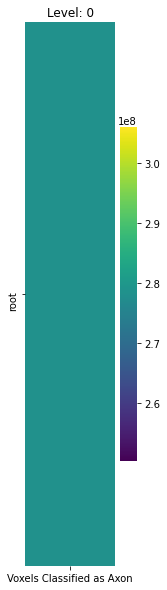

3


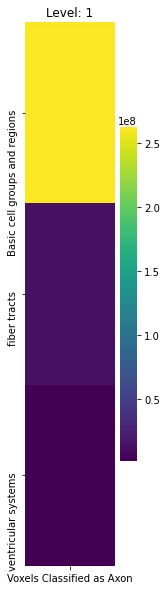

13


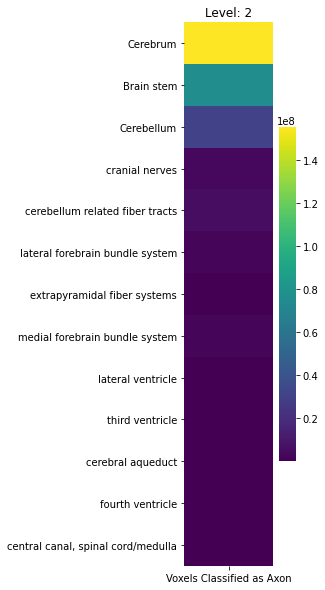

31


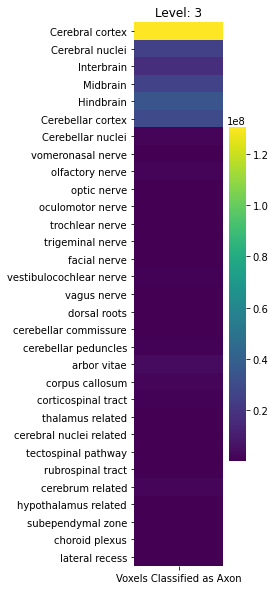

57


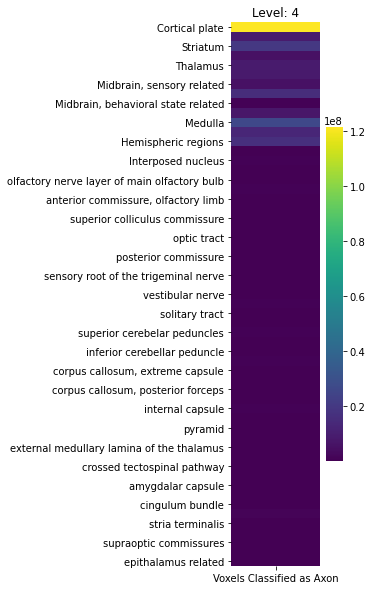

96


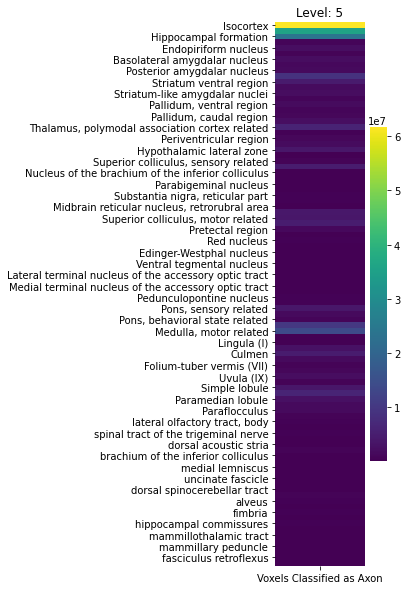

193


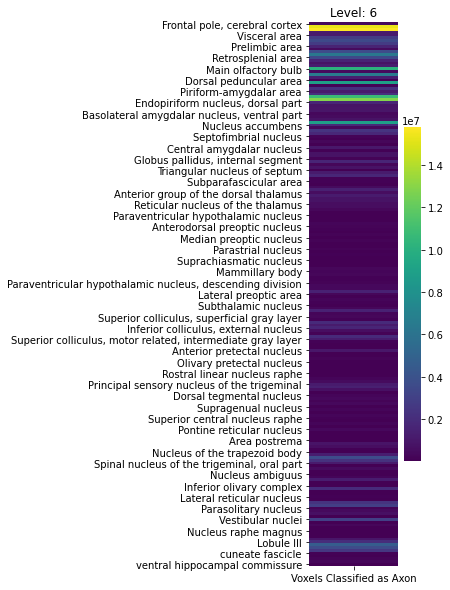

152


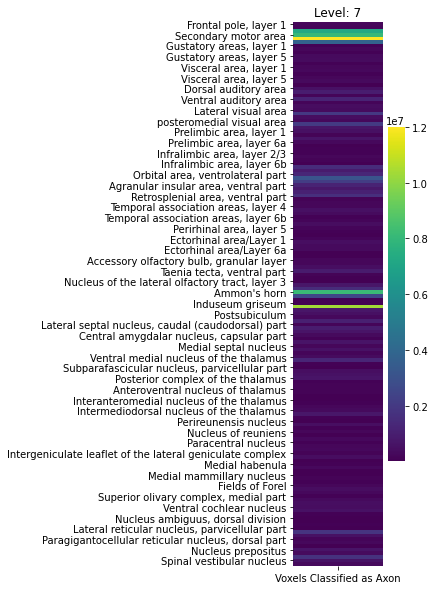

158


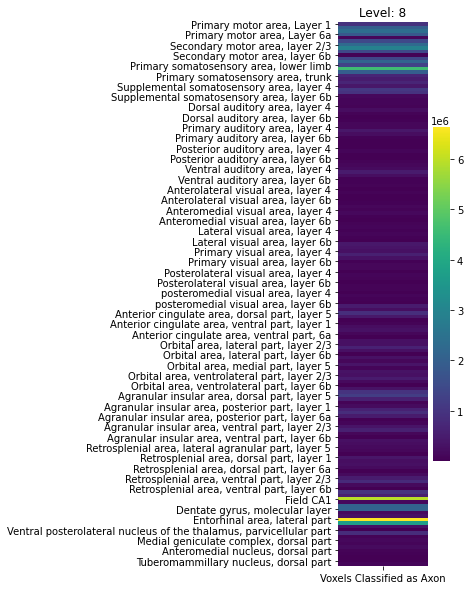

46


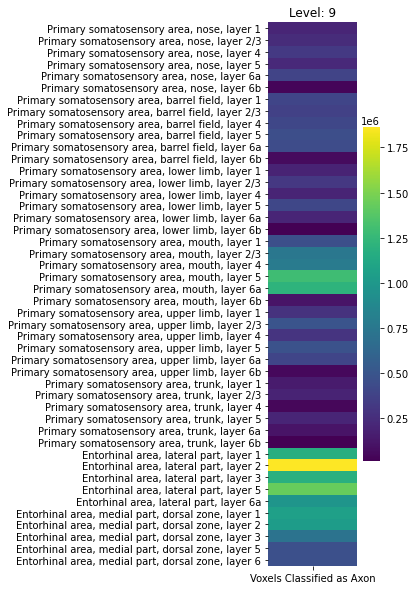

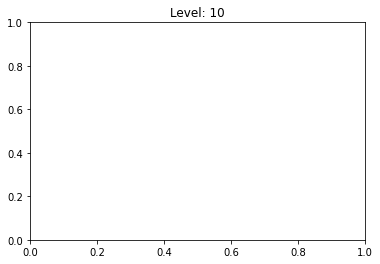

In [66]:
for level in range(max_level+1):
    keys = []
    values = []
    for node in G.nodes:
        if G.nodes[node]['level'] == level and G.nodes[node]['volume'] > 0:
            keys.append(G.nodes[node]['name'])
            values.append(G.nodes[node]['volume'])
    if len(keys) > 0:
        fig, ax = plt.subplots(figsize=(2,10))
        print(len(keys))
        df = pd.DataFrame({"Voxels Classified as Axon": values}, index=keys)
        plot = sns.heatmap(ax=ax, data=df, fmt="g", cmap='viridis', annot_kws={"size": 50})
        #plot.set_xticklabels(plot.get_xmajorticklabels(), fontsize = 18)
        #plot.set_yticklabels(plot.get_ymajorticklabels(), fontsize = 18, rotation=45)
    plt.title(f"Level: {level}")
    plt.show()
    

# Brain 4

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_647"
mip = 0
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_561"
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_488"
vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
print(vol_endo.shape)

#dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
#vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

#dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/atlas_to_target"
#vol_reg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

centers_train = []
centers_val = [[4781, 3581, 1861], [2982, 482, 1841], [2258, 6504, 1392], [2884, 2434, 1392], [1659, 4108, 1392], [3457, 5082, 1392], [2850, 5163, 3116]]

# Old

### Read swcs

In [ ]:
from brainlit.utils.Neuron_trace import NeuronTrace
from pathlib import Path
from scipy.ndimage import distance_transform_edt

In [ ]:
swc_path = Path("/Users/thomasathey/Documents/mimlab/mouselight/ailey/" + part + "_traces/")

swc_files = list(swc_path.glob("**/*.swc"))

paths_total = []
for swc_num, swc in enumerate(swc_files):

    swc_trace = NeuronTrace(path=str(swc))
    paths = swc_trace.get_paths()
    offset_diff, _, _, _ = swc_trace.get_df_arguments()

    for path_num, p in enumerate(paths):
        paths_total.append(p)

In [ ]:
swc_mask = 0*mask
for path in paths_total:
    path = path.astype(int)
    swc_mask[path[:,0], path[:,1], path[:,2]] = 1
    
edt = distance_transform_edt(swc_mask==0)
swc_mask[edt < 2] = 1

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.swapaxes(image,0,2))
viewer.add_labels(np.swapaxes(mask,0,2))
#viewer.add_labels(swc_mask)
#viewer.add_shapes(data=paths_total, shape_type='path', edge_width=1.0, edge_color='blue', opacity=0.8)

In [ ]:
tpr = np.sum(np.logical_and(swc_mask, np.swapaxes(mask,0,2)))/np.sum(swc_mask)
fpr = np.sum(np.logical_and(swc_mask==0, np.swapaxes(mask==1,0,2)))/np.sum(swc_mask==0)
print(f"TPR: {tpr}, FPR: {fpr}")

# Make annotation layer

Making new annotation layer
-output data and x,y,z bounds

In [ ]:
vol_bg.volume_size

cannot write to https link, can write to s3 link

In [ ]:

dir = "s3://smartspim-precomputed-volumes/2021_07_01_Sert_Cre_B/axon_mask"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_bg.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_bg.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 128, 128, 2 ], # units are voxels
    volume_size     = vol_bg.volume_size, # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

In [ ]:
vol_mask.volume_size

In [ ]:

image_fg = vol_fg[2432:2560, 3584:3712, 2400:2440]
image_bg = vol_bg[2432:2560, 3584:3712, 2400:2440]
image_2channel = np.stack([image_bg, image_fg], axis=0)
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
with h5py.File(fname, "w") as f:
    dset = f.create_dataset("image_2channel", data=image_2channel)

In [ ]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5
try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

In [ ]:
vol_mask[2432:2560, 3584:3712, 2400:2440, 0] = mask.astype('uint64')

In [ ]:
mask2 = vol_mask[2432:2560, 3584:3712, 2400:2440, 0]
mask2.shape

In [ ]:
mask.shape

https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=E-917tNc_GylnQ

## Brainlit example

In [ ]:
dir = "s3://open-neurodata/brainlit/brain2/axons"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_brainlit.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_brainlit.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 68, 52, 80 ], # units are voxels
    volume_size     = vol_brainlit.volume_size, # e.g. a cubic millimeter dataset
)
vol = CloudVolume(dir, info=info)
vol.commit_info()

In [ ]:
import numpy as np 

In [ ]:
a = np.zeros((68,52,80), dtype='uint64')
a[30:35,:,:] = 1
vol[:68,:52,:80] = a

# Second sample

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"

vol_fg = CloudVolume(dir)

## Download and save samples

In [ ]:
pos_centers = [[3071, 765, 2342], [5065, 3455, 2342], [3262, 7854, 2342]] #tectum, cortex, olfactory bulb
neg_centers = [[3557, 4797, 2342], [1564, 1997, 2342], [1606, 5204, 2342]] #?, edge of brain/tectum, white matter
radius = 100

for i, center in enumerate(pos_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/on_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)


for i, center in enumerate(neg_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/off_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

## Read ilastik results

In [ ]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + ".h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + "_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5

try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

brain 1

In [ ]:
from brainlit.utils import NeuroglancerSession

In [ ]:
vol_im1 = CloudVolume('https://open-neurodata.s3.amazonaws.com/brainlit/brain1', parallel=1, mip=0, fill_missing=True)
vol_skel1 = CloudVolume('precomputed://https://open-neurodata.s3.amazonaws.com/brainlit/brain1_segments')
skel2 = vol_skel1.skeleton.get(11)
skel2.vertices
#session = NeuroglancerSession("s3://open-neurodata/brainlit/brain1", 0)

In [ ]:
coord = skel2.vertices[0,:]
coord = np.divide(coord, vol_im1.resolution)

In [ ]:
coord = [19796.43356643, 14046.11235955,  5254.32142857]
coord = [int(c) for c in coord]
image = vol_im1[coord[0]-50:coord[0]+50, coord[1]-50:coord[1]+50, coord[2]-50:coord[2]+50]
image = np.squeeze(image)
image.shape

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)
napari.run()